# Adjust CSV

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(r"C:\Users\krish\ai-power-converter\machine-learning\simulation_results_8000.csv")

# Specify the columns you want to remove
columns_to_remove = ["No"]  # Specify the columns you want to remove

# Drop the specified columns
df_truncated = df.drop(columns=columns_to_remove)

# Save the truncated DataFrame back to a CSV file
df_truncated.to_csv("modified_8000_dataset.csv", index=False)


# Search N and H

Epoch 1/50, Loss: 3.2939271926879883, Val Loss: 2.681326389312744
Epoch 2/50, Loss: 1.274302363395691, Val Loss: 0.9876722097396851
Epoch 3/50, Loss: 0.7180017828941345, Val Loss: 0.9148547649383545
Epoch 4/50, Loss: 0.663760781288147, Val Loss: 0.8385315537452698
Epoch 5/50, Loss: 0.6353704333305359, Val Loss: 0.7678758502006531
Epoch 6/50, Loss: 0.6001764535903931, Val Loss: 0.8483052253723145
Epoch 7/50, Loss: 0.5800972580909729, Val Loss: 0.6978343725204468
Epoch 8/50, Loss: 0.5695140957832336, Val Loss: 0.6782810688018799
Epoch 9/50, Loss: 0.5585423111915588, Val Loss: 0.684329092502594
Epoch 10/50, Loss: 0.541283130645752, Val Loss: 0.6415119171142578
Epoch 11/50, Loss: 0.5430349707603455, Val Loss: 0.628566563129425
Epoch 12/50, Loss: 0.5371508598327637, Val Loss: 0.6205554008483887
Epoch 13/50, Loss: 0.5233910083770752, Val Loss: 0.6089562773704529
Epoch 14/50, Loss: 0.5241984128952026, Val Loss: 0.6002858281135559
Epoch 15/50, Loss: 0.5172906517982483, Val Loss: 0.593573927879

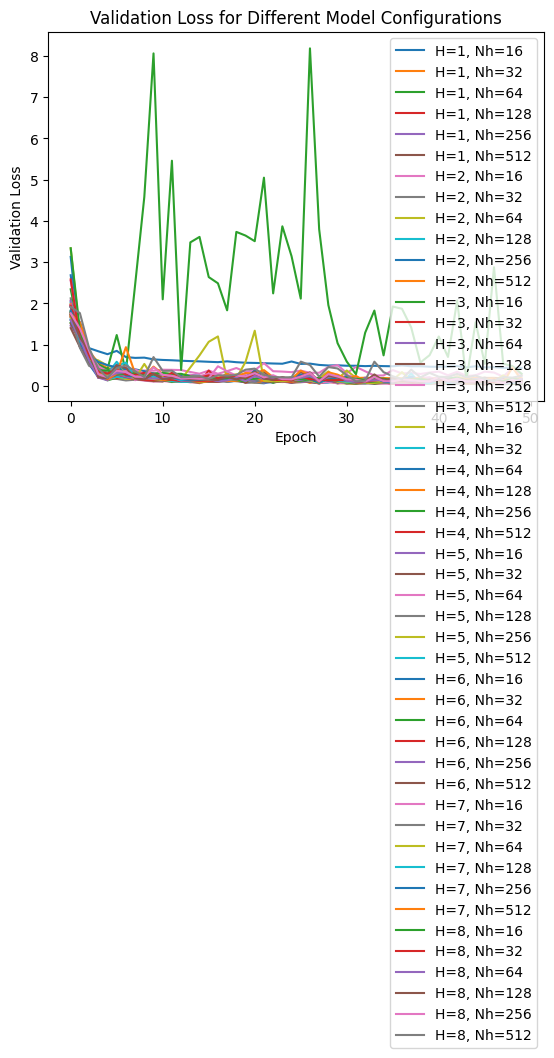

Model with H=1 and Nh=16:
MSE: 0.3181613087654114
MAE: 0.2063882072159
RMSE: 0.5640579409465033
R-squared: 0.883702515976029
MAPE: 24.982602602904404%
Model with H=1 and Nh=32:
MSE: 0.17529286444187164
MAE: 0.15843116933767032
RMSE: 0.4186799288046605
R-squared: 0.9140553241250874
MAPE: 16.791931183440607%
Model with H=1 and Nh=64:
MSE: 0.14358505606651306
MAE: 0.14583004862868143
RMSE: 0.37892620722054615
R-squared: 0.9213998237350127
MAPE: 15.990606589073595%
Model with H=1 and Nh=128:
MSE: 0.1033678650856018
MAE: 0.13260760569565286
RMSE: 0.3215087259692706
R-squared: 0.9418862281631135
MAPE: 12.96552914061122%
Model with H=1 and Nh=256:
MSE: 0.08981282263994217
MAE: 0.11748295866509346
RMSE: 0.2996878670192367
R-squared: 0.9494577744017972
MAPE: 12.284154709353096%
Model with H=1 and Nh=512:
MSE: 0.0865064188838005
MAE: 0.11641485898439789
RMSE: 0.29411972879174586
R-squared: 0.9449197483649326
MAPE: 12.655561844593619%
Model with H=2 and Nh=16:
MSE: 0.17562688887119293
MAE: 0.1755

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\modified_8000_dataset.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

# Initialize a dictionary to store the training history for each configuration
histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
# H_values = [1, 2, 3, 4, 5]  # Number of hidden layers
# Nh_values = [32, 64, 128]  # Number of neurons per hidden layer
# Additional values for H and Nh
# H_values = [1, 2, 3, 4, 5, 6, 7]  # Number of hidden layers
# Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer
H_values = [1, 2, 3, 4, 5, 6, 7, 8]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512]  # Number of neurons per hidden layer



# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(3,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(6, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model and store the training history
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0, callbacks=[PrintEpochInfo()])
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


## Ranking

In [12]:
import os
import pandas as pd

# Sort configurations based on MSE in ascending order
sorted_configs_mse = sorted(mses.items(), key=lambda x: x[1])

# Sort configurations based on MAE in ascending order
sorted_configs_mae = sorted(maes.items(), key=lambda x: x[1])

# Sort configurations based on RMSE in ascending order
sorted_configs_rmse = sorted(rmses.items(), key=lambda x: x[1])

# Sort configurations based on R-squared in descending order
sorted_configs_r2 = sorted(r2_scores.items(), key=lambda x: x[1], reverse=True)

# Sort configurations based on MAPE in ascending order
sorted_configs_mape = sorted(mapes.items(), key=lambda x: x[1])

# Rank each combination based on its position in the sorted lists
ranking = {}
for i, (config, _) in enumerate(sorted_configs_mse):
    ranking[config] = i + 1

for i, (config, _) in enumerate(sorted_configs_mae):
    ranking[config] += i + 1

for i, (config, _) in enumerate(sorted_configs_rmse):
    ranking[config] += i + 1

for i, (config, _) in enumerate(sorted_configs_r2):
    ranking[config] += i + 1

for i, (config, _) in enumerate(sorted_configs_mape):
    ranking[config] += i + 1

# Sort configurations based on their overall ranking
sorted_ranking = sorted(ranking.items(), key=lambda x: x[1])

# Display the rankings
for rank, (config, _) in enumerate(sorted_ranking, 1):
    print(f'{rank}. Combination {config}: Overall rank {rank}')



# Create the 'ranking' folder if it doesn't exist
folder_path = 'ranking'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Create a DataFrame for the rankings
rankings_df = pd.DataFrame(sorted_ranking, columns=['Combination', 'Overall_Rank'])

# Define the file path for saving the CSV file
file_path = os.path.join(folder_path, 'rankings_5.csv')

# Save the DataFrame to a CSV file
rankings_df.to_csv(file_path, index=False)

print(f"Rankings saved to '{file_path}'")


1. Combination (2, 128): Overall rank 1
2. Combination (3, 256): Overall rank 2
3. Combination (2, 256): Overall rank 3
4. Combination (4, 256): Overall rank 4
5. Combination (3, 128): Overall rank 5
6. Combination (4, 128): Overall rank 6
7. Combination (5, 256): Overall rank 7
8. Combination (7, 256): Overall rank 8
9. Combination (3, 64): Overall rank 9
10. Combination (3, 512): Overall rank 10
11. Combination (7, 128): Overall rank 11
12. Combination (5, 64): Overall rank 12
13. Combination (2, 512): Overall rank 13
14. Combination (6, 64): Overall rank 14
15. Combination (4, 512): Overall rank 15
16. Combination (1, 512): Overall rank 16
17. Combination (5, 128): Overall rank 17
18. Combination (1, 256): Overall rank 18
19. Combination (6, 256): Overall rank 19
20. Combination (5, 32): Overall rank 20
21. Combination (2, 64): Overall rank 21
22. Combination (8, 256): Overall rank 22
23. Combination (4, 64): Overall rank 23
24. Combination (6, 512): Overall rank 24
25. Combination 

### Results

## Try spesific N and H

In [ ]:
# Specify the combination you want to call
H = 6
Nh = 128

# Retrieve the model for the specified combination
selected_model = histories[(H, Nh)].model

# Use the trained model to make predictions on the testing set
predictions = selected_model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Machine Learning

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\machine-learning\modified_8000_dataset.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Scale input features to range [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

# Define the neural network model
# model = tf.keras.Sequential([
#     tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
#     tf.keras.layers.Dense(64, activation='relu'),          # Hidden layer 1
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(64, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(64, activation='relu'),          # Hidden layer 3
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(6)                               # Output layer with 3 neurons
# ])

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
    tf.keras.layers.Dense(64, activation='relu'),          # Hidden layer 1
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(64, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(64, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),     
    tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with custom callback to print information at the end of each epoch
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[PrintEpochInfo()], verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing Set

In [ ]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Optionally, save the model
model.save("ripples_prediction_model.h5")


## Save Model

In [ ]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Optionally, save the model
model.save("ripples_prediction_model.h5")
